# Analisis exploratorio de las variables en relación a los Spoilers en comentarios de IMDB

## 1. Procesamiento de datos

In [1]:
# Importamos las librerias generales para el proyecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import seaborn as sns

from collections import Counter

In [2]:
# Lectura de los datos iniciales
movies_details = pd.read_json("./data/movies/IMDB_movie_details.json", lines=True)
movies_reviews = pd.read_json("./data/movies/IMDB_reviews.json", lines=True)
movies_info = pd.read_csv('./data/movies_info/IMDb movies.csv')

In [3]:
# Eliminamos columnas inncesarias o repetidas para hacer 
movies_details_pre = movies_details[['movie_id', 'rating','release_date']]
movies_info_pre = movies_info[['imdb_title_id', 'original_title',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics']]

In [4]:
# Esta es una función para convertir diferentes tipos de moneda a dólares americanos

# Input: (String, Number) Un String que representa la mondeda (e.g., 'EUR') y el monto
# Output: (Number/None) Valor en dólares resultante / None si el valor era NaN
def convert_to_usd(currency, amount):
    if pd.isna(currency):
        return None
    rates = {'$': 1,'GBP': 0.76, 'FRF': 5.826, 'DEM': 1.733, 'CAD': 1.29, 'RUR': 73.77, 'EUR': 1.13, 'IEP': 0.665779, 'JPY': 113.74, 'TRL': 14.39, 'INR': 76.11, 'KRW': 1185.26, 'AUD': 1.41, 'BRL': 5.68}
    return amount / rates[currency]

In [5]:
# Combinamos los datasets para tener los datos completos
movies_data = movies_details_pre.merge(movies_info_pre, right_on="imdb_title_id", left_on="movie_id")

# Corregimos errores de repetición y de formato de los valores
movies_data = movies_data.drop(columns=["imdb_title_id"])
movies_data["currency"] = movies_data["budget"].str.split(" ", n = 1, expand = True)[0]
movies_data["budget"] = movies_data["budget"].str.split(" ", n = 1, expand = True)[1]
movies_data["budget"] = movies_data["budget"].astype('float64')
movies_data['budget'] = movies_data.apply(lambda p: convert_to_usd(p.currency, p.budget), axis=1)
movies_data = movies_data.drop(columns=["currency"])
movies_data["usa_gross_income"] = movies_data["usa_gross_income"].str.split(" ", n = 1, expand = True)[1]
movies_data["usa_gross_income"] = movies_data["usa_gross_income"].astype('float64')
movies_data["worlwide_gross_income"] = movies_data["worlwide_gross_income"].str.split(" ", n = 1, expand = True)[1]
movies_data["worlwide_gross_income"] = movies_data["worlwide_gross_income"].astype('float64')
movies_data["genre"] = movies_data.genre.apply(lambda x: x.split(', '))
movies_data["language"] = movies_data.language.apply(lambda x: x.split(', '))
movies_data["actors"] = movies_data.actors.apply(lambda x: x.split(', '))
movies_data["country"] = movies_data.country.apply(lambda x: x.split(', '))
movies_data["director"] = movies_data.director.apply(lambda x: x.split(', '))
movies_data["writer"] = movies_data.writer.apply(lambda x: x.split(', '))
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'],format= '%Y-%m-%d' )

In [6]:
# Revisamos la existencia de valores NaN en las distintas columnas
movies_data.isnull().any()

movie_id                 False
rating                   False
release_date             False
original_title           False
genre                    False
duration                 False
country                  False
language                 False
director                 False
writer                   False
production_company       False
actors                   False
votes                    False
budget                    True
usa_gross_income          True
worlwide_gross_income     True
metascore                 True
reviews_from_users        True
reviews_from_critics     False
dtype: bool

In [7]:
# Comprobamos la forma de los datos para rellenar los valores NaN
movies_data.describe()

,rating,duration,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
count,1534.000000,1534.000000,1.534000e+03,1.436000e+03,1.476000e+03,1.517000e+03,1431.000000,1533.000000,1534.000000
mean,7.049022,116.722947,2.647611e+05,5.453821e+07,9.017659e+07,2.018458e+08,62.636618,658.522505,224.512386
std,0.956515,22.759115,2.682681e+05,5.475451e+07,9.706665e+07,2.561669e+08,17.657524,676.416985,162.416418
min,2.400000,67.000000,1.413000e+03,6.000000e+00,5.090000e+02,5.760000e+02,9.000000,5.000000,1.000000
25%,6.400000,101.000000,9.080425e+04,1.500000e+07,2.556240e+07,3.528179e+07,50.000000,256.000000,106.250000
50%,7.100000,113.000000,1.863885e+05,3.500000e+07,5.840391e+07,1.159009e+08,63.000000,468.000000,178.000000
75%,7.800000,128.000000,3.455498e+05,7.525000e+07,1.242690e+08,2.647710e+08,75.000000,828.000000,311.750000
max,9.500000,321.000000,2.278845e+06,3.170000e+08,9.366622e+08,2.790439e+09,100.000000,8232.000000,999.000000


In [8]:
# Rellenamos los valores con la mediana para que no se vean afectados por los "outliers" y comprobamos nuevamente
movies_data = movies_data.fillna(movies_data.median())
movies_data.isnull().any()

movie_id                 False
rating                   False
release_date             False
original_title           False
genre                    False
duration                 False
country                  False
language                 False
director                 False
writer                   False
production_company       False
actors                   False
votes                    False
budget                   False
usa_gross_income         False
worlwide_gross_income    False
metascore                False
reviews_from_users       False
reviews_from_critics     False
dtype: bool

In [9]:
# Comprobamos valores NaN en los datos de las reviews
movies_reviews.isnull().any()

review_date       False
movie_id          False
user_id           False
is_spoiler        False
review_text       False
rating            False
review_summary    False
dtype: bool

In [10]:
# Creamos el dataframe con la proporcion de spoilers para cada pelicula
total_movies_reviews = pd.DataFrame(movies_reviews.groupby(by="movie_id").count()["is_spoiler"])
spoiler_movies_reviews = pd.DataFrame(movies_reviews[movies_reviews["is_spoiler"]==True].groupby(by="movie_id").count()["is_spoiler"])
reviews_data = spoiler_movies_reviews.merge(total_movies_reviews, right_index=True, left_index=True)
reviews_data.rename(columns={"is_spoiler_y":"total_reviews", "is_spoiler_x": "spoiler_reviews"}, inplace=True)
reviews_data["proportional"] = reviews_data["spoiler_reviews"] / reviews_data["total_reviews"]

# Juntamos con el anterior dataset que teniamos para tener el final
final_movies_data = movies_data.merge(reviews_data, right_index=True, left_on="movie_id")
final_movies_data.head(2)

,movie_id,rating,release_date,original_title,genre,duration,country,language,director,writer,...,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,spoiler_reviews,total_reviews,proportional
0,tt0105112,6.9,1992-06-05,Patriot Games,"[Action, Thriller]",117,[USA],[English],[Phillip Noyce],"[Tom Clancy, W. Peter Iliff]",...,100936,45000000.0,83351587.0,178051587.0,64.0,154.0,62.0,17,100,0.170000
1,tt1204975,6.6,2013-11-01,Last Vegas,"[Comedy, Drama]",105,[USA],[English],[Jon Turteltaub],[Dan Fogelman],...,126219,28000000.0,63914167.0,134409025.0,48.0,201.0,229.0,50,157,0.318471


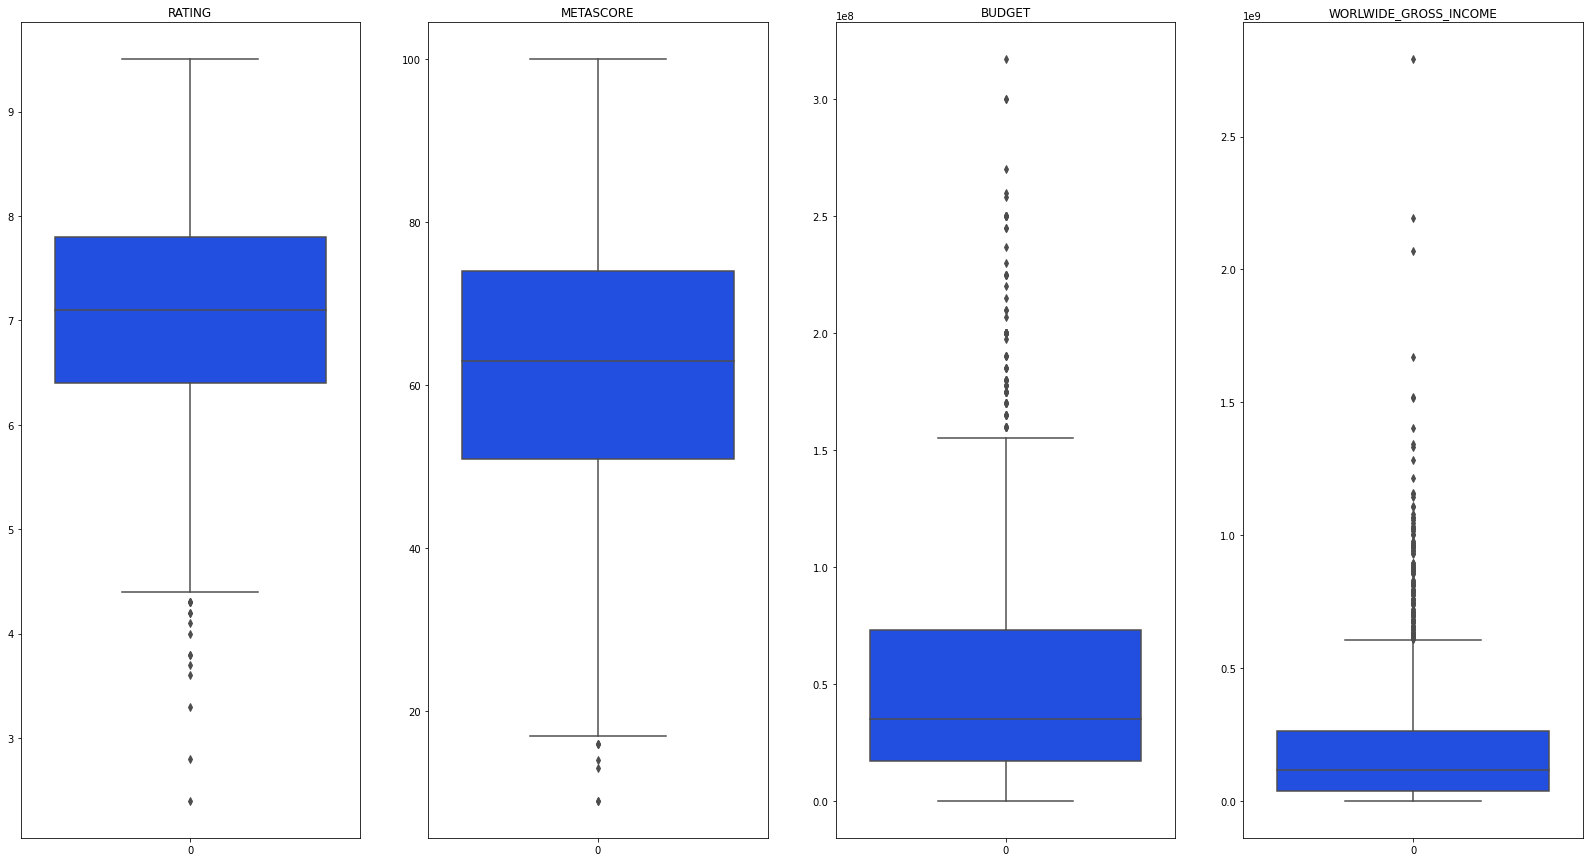

In [11]:
# Graficamos los outliers de las variables que más nos interesen
data = ['rating', 'metascore', 'budget', 'worlwide_gross_income']
fig, ax = plt.subplots(1,4,figsize= (28,15))

for i in range(len(data)):
    sns.boxplot(ax=ax[i], data=final_movies_data[data[i]], palette="bright").set_title(data[i].upper())

Podemos observar que en las distintas variables que analizamos existen varios outliers, en el caso de los ratings se aprecia que la mediana ronda un valor de 7/10 y un rango de valores comùnes entre 4.3/10 y 9.5/10, en base a este feature podemos observar outliers representados en puntos menores al lìmite menor previamente dicho.

En el caso del feature "metascore", podemos observar que la mediana es de 65 aproximadamente, mientras que sus rangos de valores comúnes ronda entre 18 y 100. Al igual 
que en el caso de ratings podemos observar outliers debajo del lìmite inferior comentado.

Al observar el feature "budget" podemos ver que contamos con considerablemente más outliers que los anteriores features. Indicando la gran brecha que existe entre el presupuesto invertido en cada película. La mediana del presupuesto es aproximadamente 4 millones de dolares y el rango de valores comúnes ronda entre 2 y 7 millones.

Finalmente, el "worlwide_gross_income" refleja algo parecido al "budget", donde se pueden observar ingresos excesivamente grandes comparados con los ingresos standard, siendo estos los outliers. La mediana del de los ingresos mundiales es aproximadamente 2 millones de dolares y el rango de valores comúnes ronda entre medio millon y 3 millones.

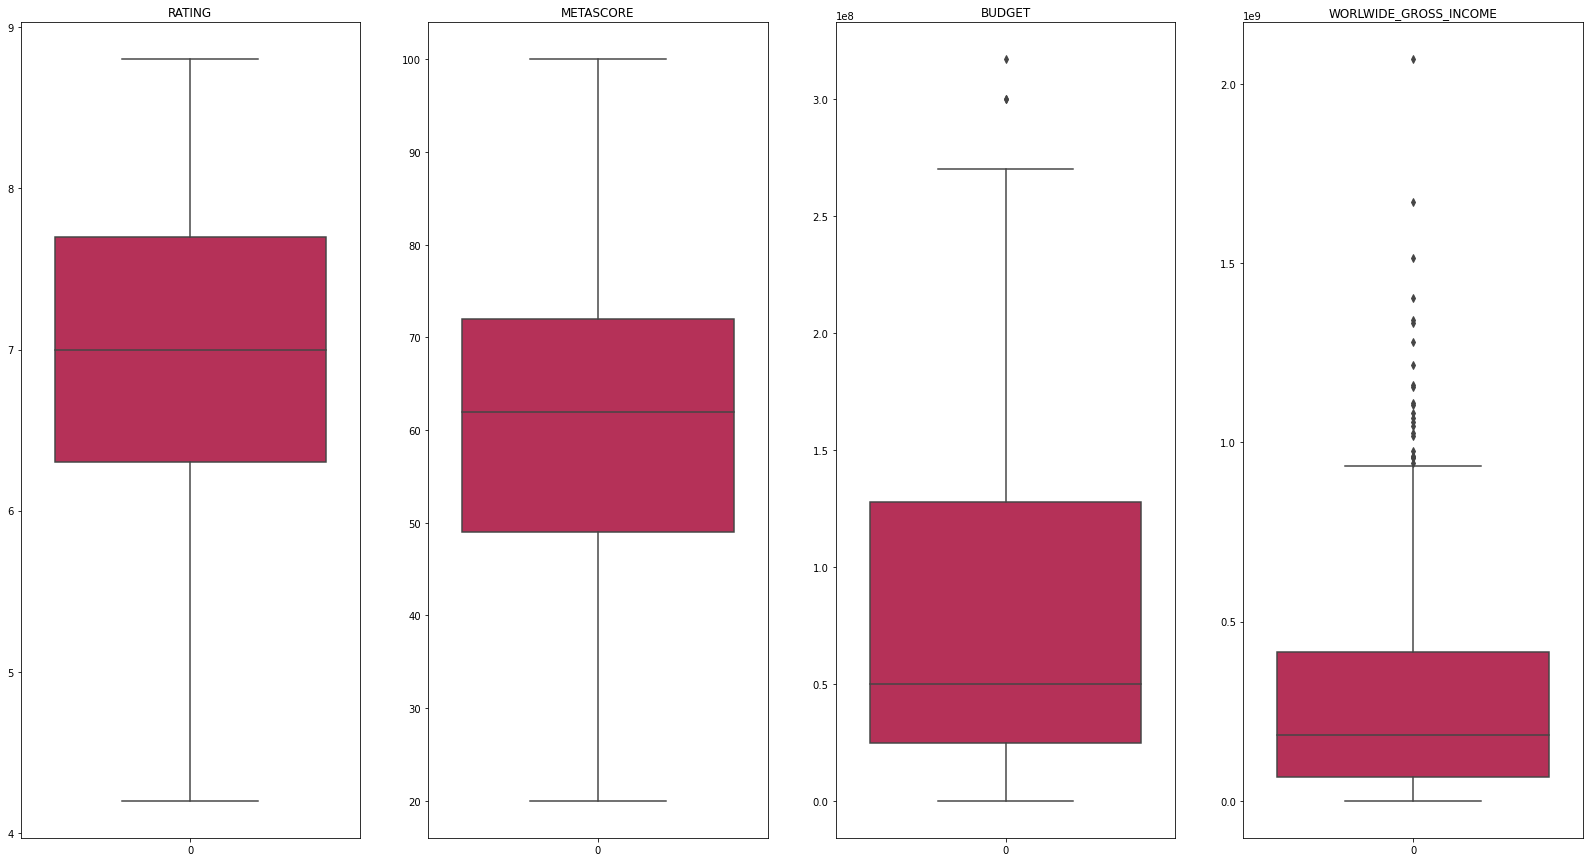

In [12]:
# Comparamos el gráfico anterior con los datos solo de las peliculas con mayor proporción de spoilers
final_movies_spoiler = final_movies_data[final_movies_data["proportional"] > final_movies_data["proportional"].quantile(q=0.75)].reset_index(drop=True)
fig, ax = plt.subplots(1,4,figsize= (28,15))

for i in range(len(data)):
    sns.boxplot(ax=ax[i], data=final_movies_spoiler[data[i]], palette="rocket").set_title(data[i].upper())

En comparación con el anterior gráfico mostrado, se pueden observar rangos de valores similares. Sin embargo se aprecia una disminución drastica de la cantidad de outliers en practicamente todos los features presentados.

In [13]:
# Obtenemos los coeficientes de relación entre los distintos features
final_movies_data.corr(method ='pearson')

,rating,duration,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,spoiler_reviews,total_reviews,proportional
rating,1.000000,0.362784,0.519673,-0.114417,0.075141,0.076951,0.695529,0.319918,0.253759,0.236652,0.309142,0.006895
duration,0.362784,1.000000,0.325580,0.233352,0.193519,0.234550,0.232941,0.335113,0.218105,0.265450,0.303235,0.066053
votes,0.519673,0.325580,1.000000,0.296661,0.512981,0.512205,0.360032,0.757729,0.506690,0.635335,0.712126,0.176466
budget,-0.114417,0.233352,0.296661,1.000000,0.651887,0.725559,-0.141208,0.361821,0.435849,0.422683,0.334377,0.270524
usa_gross_income,0.075141,0.193519,0.512981,0.651887,1.000000,0.935139,0.075363,0.493901,0.435916,0.434226,0.380393,0.215518
worlwide_gross_income,0.076951,0.234550,0.512205,0.725559,0.935139,1.000000,0.057381,0.489802,0.488340,0.462906,0.391915,0.264178
metascore,0.695529,0.232941,0.360032,-0.141208,0.075363,0.057381,1.000000,0.234681,0.277715,0.180644,0.217015,0.031920
reviews_from_users,0.319918,0.335113,0.757729,0.361821,0.493901,0.489802,0.234681,1.000000,0.507046,0.695972,0.782183,0.153879
reviews_from_critics,0.253759,0.218105,0.506690,0.435849,0.435916,0.488340,0.277715,0.507046,1.000000,0.660274,0.524940,0.503294
spoiler_reviews,0.236652,0.265450,0.635335,0.422683,0.434226,0.462906,0.180644,0.695972,0.660274,1.000000,0.884318,0.573279


Haciendo un análisis entre la correlación de variables, notamos que no existen fuertes dependencias entre las variables escogidas, sin embargo, podemos destacar que las variables de budget, worldwide_gross y usa_gross tienen cierto grado de relación entre ellas. Por otro lado se puede observar una cierta relación entre reviews_from_critics con reviews_from_users y spoiler_reviews.

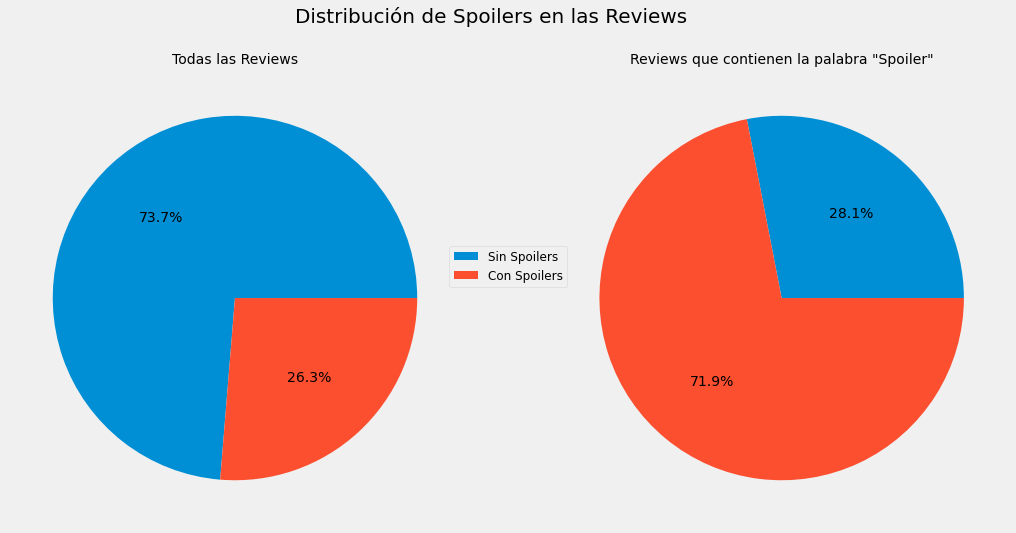

In [14]:
# Creamos un dataset para observar los spoilers en las reviews y las reviews que tienen la palabra 'spoiler'
reviews_spoiler = pd.DataFrame()
reviews_spoiler['is_spoiler'] = movies_reviews['is_spoiler']
reviews_spoiler['has_word_spoiler'] = movies_reviews['review_text'].apply(lambda text: 1 if 'spoiler' in text.lower() else 0)

# Separamos los datos para crear piecharts individuales
pie1 = reviews_spoiler['is_spoiler'].value_counts().reset_index().sort_values(by='index')
pie2 = reviews_spoiler[reviews_spoiler['has_word_spoiler'] == 1]['is_spoiler'].value_counts().reset_index().sort_values(by='index')

with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.pie(pie1['is_spoiler'], autopct="%.1f%%")
    ax1.set_title('Todas las Reviews', fontsize=14)

    ax2.pie(pie2['is_spoiler'], autopct="%.1f%%")
    ax2.set_title('Reviews que contienen la palabra "Spoiler"', fontsize=14)

    plt.suptitle('Distribución de Spoilers en las Reviews', fontsize=20)
    fig.legend(labels=['Sin Spoilers', 'Con Spoilers'], loc='center', fontsize=12)

    plt.show()

Podemos observar que de 573913 reviews analizados, el 26.3% contienen spoilers, indicando que la mayor parte de reviews estan libres de spoilers.

Además como curiosidad podemos ver que de las reviews que contienen la palabra 'spoiler', el 71.9% si contiene un verdadero spoiler. Esto podria indicar que la mayor parte de personas da un pequeño aviso para los demás lectores al momento de dar un spoiler, el otro porcentaje probablemente se esta quejando de los spoilers de otras personasmovies_reviews.

In [15]:
# Contamos la cantidad de veces que se repiten las palabras en las reviews que contienen spoilers
counter_root = Counter()
movies_reviews_spoiler = movies_reviews[movies_reviews["is_spoiler"] == True].reset_index(drop=True)
movies_reviews_spoiler.review_text.apply(lambda x: counter_root.update(Counter(x.lower().split(" "))))

0         None
1         None
2         None
3         None
4         None
          ... 
150919    None
150920    None
150921    None
150922    None
150923    None
Name: review_text, Length: 150924, dtype: object

Text(0.5, 1.0, 'Palabras más repetidas')

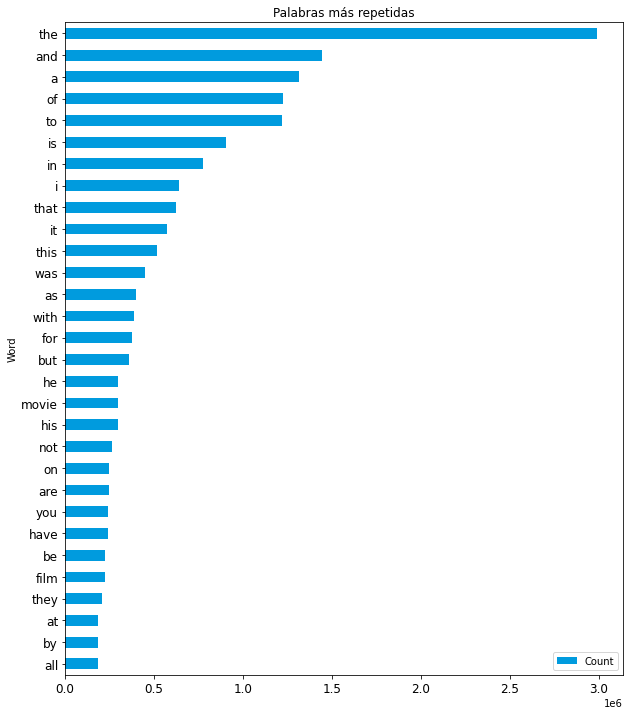

In [16]:
# Obtenemos la cantidad de repeticiones por palabras y los ordenamos para graficar
counter_root_df = pd.DataFrame.from_records(counter_root.most_common(30), columns =['Word', 'Count'])
counter_root_df = counter_root_df.sort_values('Count',ascending=True)
counter_root_df.plot.barh(x='Word', y='Count', figsize=(10,12), color="#009bde", fontsize=12).set_title("Palabras más repetidas")

Vemos que las palabras que más se repiten en las reseñas que contienen spoiler son del tipo conectoras y por ende no nos brindan mucha información. Para una análisis posterior se pretende eliminar estos tipos a modo de obtener una visión más amplia y visualizar palabras que realmente son relevantes en reseñas que en efecto presentan spoilers.